In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from RnaVeloDataset import RnaVeloDataset
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
dataset = RnaVeloDataset(root='data/')
len(dataset)

ctivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
5_backbone/linear_3_1_1_150
Transforming to str index.
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', s

60

In [19]:
np.sort(np.array(dataset[0].adj[0][18]))

array([-0.33337935, -0.25800605, -0.06828548,  0.02127748,  0.3289831 ,
        3.        ,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [20]:
t = np.arange(13)
train_mask = list(t) + list(t + 15) + list(t + 30) + list(t + 45)
val_mask = [13, 14, 28, 29, 43, 44, 58, 59]

In [21]:
def train():
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label))
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        pred = model(data).detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
dataset = RnaVeloDataset(root='data/')
batch_size = 1
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = BaseModel(dataset.num_features, device).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=0.01)

best_val_perf = test_perf = 0

train_list = []
val_list = []
for epoch in range(251):
    train_loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 1.4851, Train: 0.6184, Val: 0.6065
Epoch: 010, Loss: 0.2424, Train: 0.2290, Val: 0.2683
Epoch: 020, Loss: 0.2178, Train: 0.2112, Val: 0.2817
Epoch: 030, Loss: 0.1939, Train: 0.1878, Val: 0.2527
Epoch: 040, Loss: 0.1824, Train: 0.1786, Val: 0.2416
Epoch: 050, Loss: 0.1806, Train: 0.1719, Val: 0.2589
Epoch: 060, Loss: 0.1751, Train: 0.1679, Val: 0.2466
Epoch: 070, Loss: 0.1653, Train: 0.1603, Val: 0.2569
Epoch: 080, Loss: 0.1698, Train: 0.1610, Val: 0.2412
Epoch: 090, Loss: 0.1670, Train: 0.1547, Val: 0.2497
Epoch: 100, Loss: 0.1625, Train: 0.1565, Val: 0.2478
Epoch: 110, Loss: 0.1560, Train: 0.1519, Val: 0.2463
Epoch: 120, Loss: 0.1513, Train: 0.1553, Val: 0.2434
Epoch: 130, Loss: 0.1512, Train: 0.1501, Val: 0.2371
Epoch: 140, Loss: 0.1490, Train: 0.1524, Val: 0.2321
Epoch: 150, Loss: 0.1445, Train: 0.1571, Val: 0.2611
Epoch: 160, Loss: 0.1442, Train: 0.1527, Val: 0.2801
Epoch: 170, Loss: 0.1408, Train: 0.1347, Val: 0.2394
Epoch: 180, Loss: 0.1411, Train: 0.1454, Val: 

In [7]:
def scatter(data, figsize = (15,5)):
    if isinstance(data.x, torch.Tensor):
        X_pca = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X_pca = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')

    data = data.to(device)
    pred = model(data).detach().cpu().numpy().reshape(-1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.set_title("Predicted Pseudo Time")
    ax2.set_title("Simulation Time")
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax2)
    plt.figure(figsize=figsize)
    plt.show()

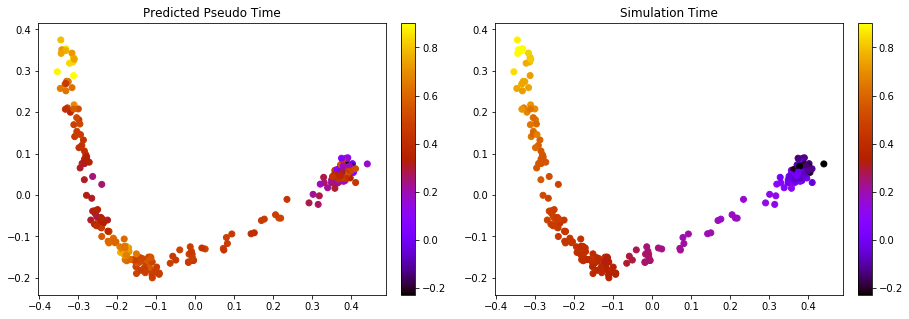

<Figure size 1080x360 with 0 Axes>

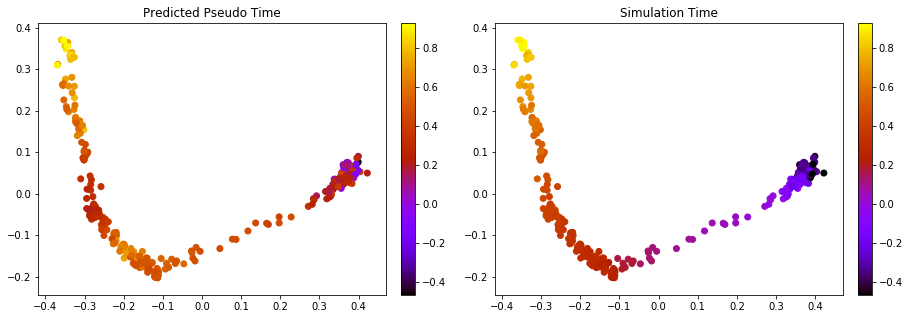

<Figure size 1080x360 with 0 Axes>

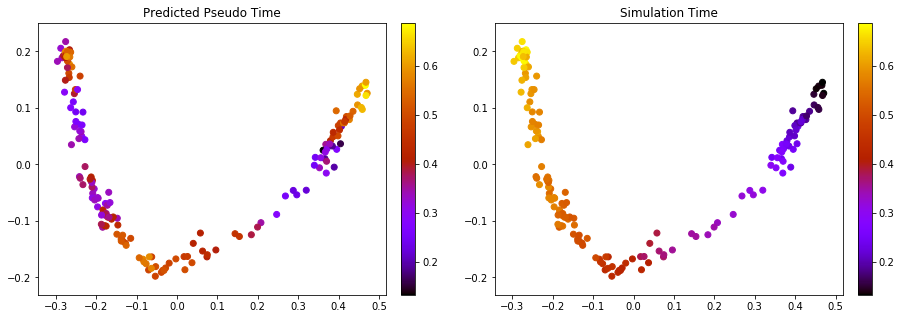

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

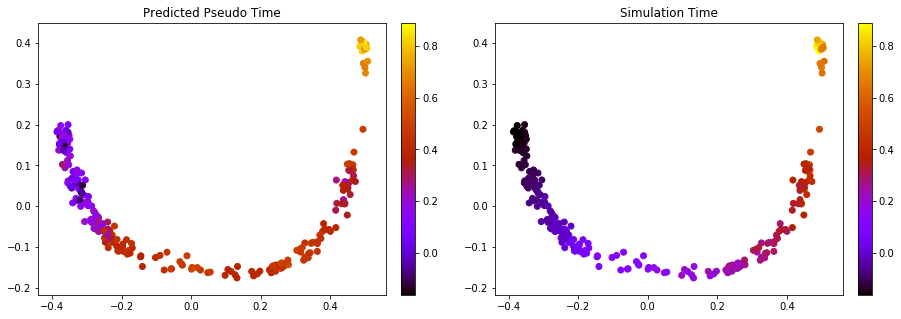

<Figure size 1080x360 with 0 Axes>

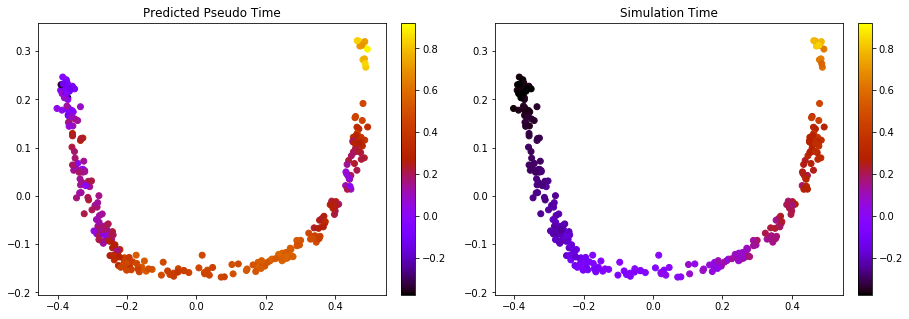

<Figure size 1080x360 with 0 Axes>

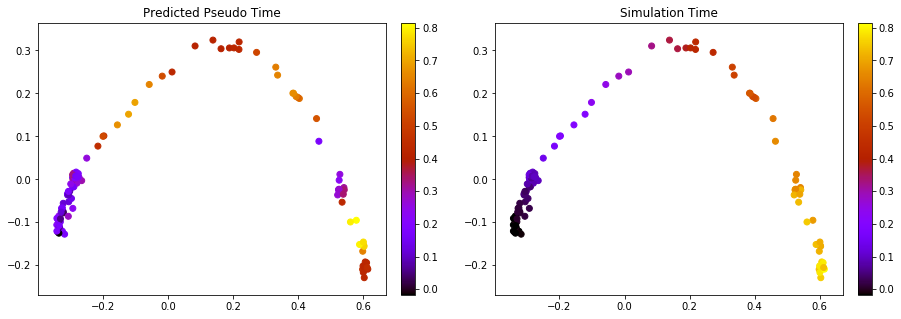

<Figure size 1080x360 with 0 Axes>

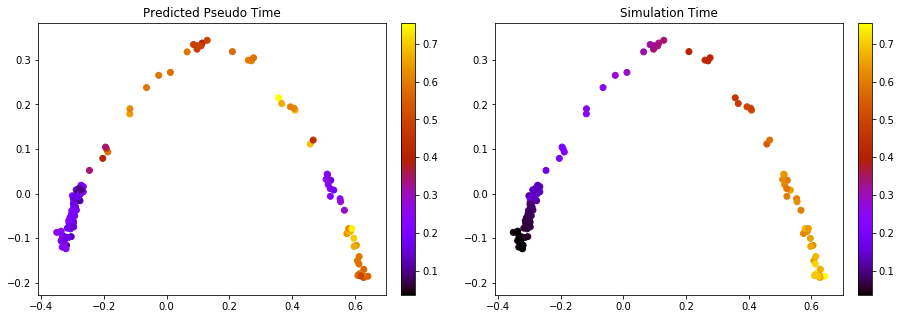

<Figure size 1080x360 with 0 Axes>

In [8]:
model.eval()
for data in val_loader:
    scatter(data)

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


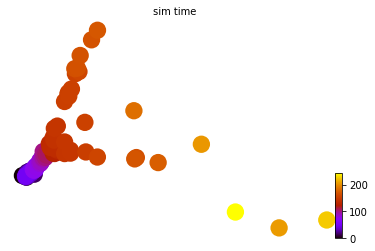

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


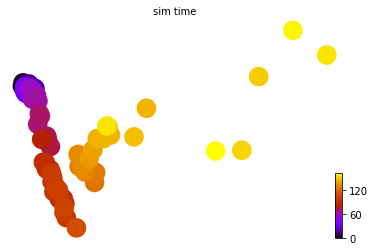

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


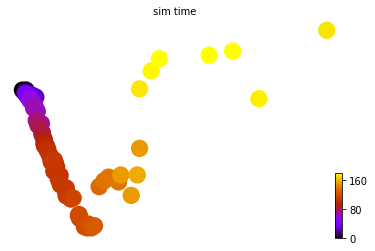

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


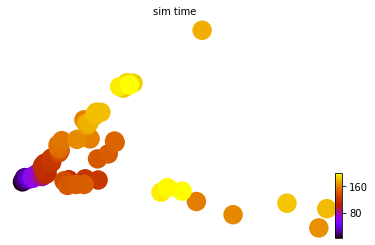

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


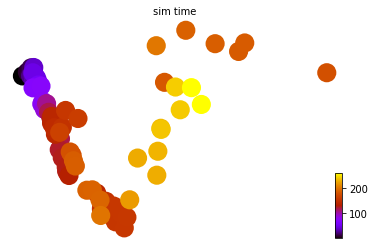

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


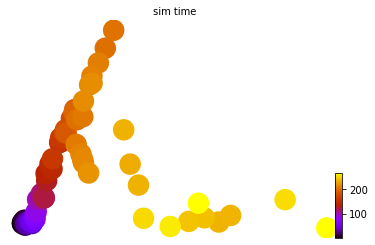

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


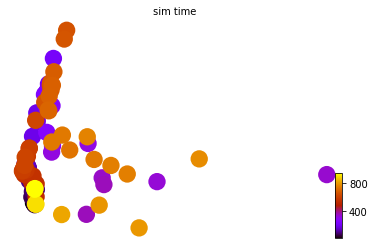

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


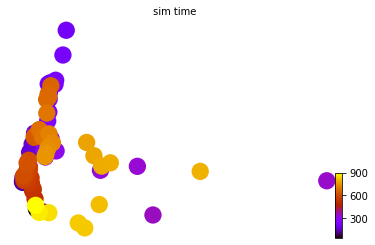

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


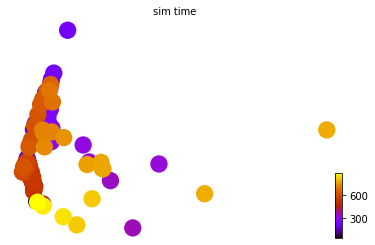

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


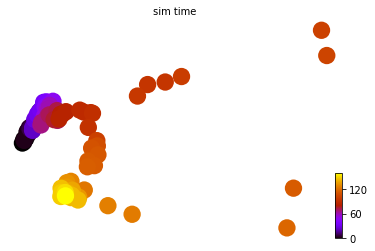

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


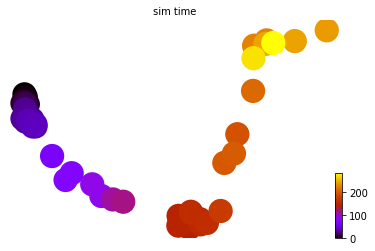

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [60]:
for i in range(0, len(adata_list), 5):
    adata = adata_list[i]
    scv.tl.velocity_graph(adata)
    scv.pl.scatter(adata, color=['sim_time'], color_map='gnuplot', legend_loc='on data', basis='pca')

###  Cycle

In [67]:
t = np.arange(13)
train_mask = list(t + 30)
val_mask = [43, 44]

In [68]:
dataset = RnaVeloDataset(root='data/')
batch_size = 2
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = BaseModel(dataset.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

best_val_perf = test_perf = 0

train_list = []
val_list = []
for epoch in range(251):
    train_loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.6072, Train: 0.6029, Val: 0.5797
Epoch: 010, Loss: 0.5755, Train: 0.5722, Val: 0.5491
Epoch: 020, Loss: 0.5404, Train: 0.5370, Val: 0.5141
Epoch: 030, Loss: 0.4981, Train: 0.4944, Val: 0.4719
Epoch: 040, Loss: 0.4460, Train: 0.4396, Val: 0.4181
Epoch: 050, Loss: 0.3700, Train: 0.3643, Val: 0.3454
Epoch: 060, Loss: 0.2943, Train: 0.2886, Val: 0.2775
Epoch: 070, Loss: 0.2621, Train: 0.2588, Val: 0.2568
Epoch: 080, Loss: 0.2570, Train: 0.2558, Val: 0.2556
Epoch: 090, Loss: 0.2560, Train: 0.2552, Val: 0.2549
Epoch: 100, Loss: 0.2564, Train: 0.2549, Val: 0.2546
Epoch: 110, Loss: 0.2560, Train: 0.2547, Val: 0.2545
Epoch: 120, Loss: 0.2565, Train: 0.2546, Val: 0.2542
Epoch: 130, Loss: 0.2564, Train: 0.2545, Val: 0.2542
Epoch: 140, Loss: 0.2559, Train: 0.2546, Val: 0.2539
Epoch: 150, Loss: 0.2559, Train: 0.2545, Val: 0.2541
Epoch: 160, Loss: 0.2574, Train: 0.2544, Val: 0.2540
Epoch: 170, Loss: 0.2563, Train: 0.2545, Val: 0.2537
Epoch: 180, Loss: 0.2569, Train: 0.2544, Val: 

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

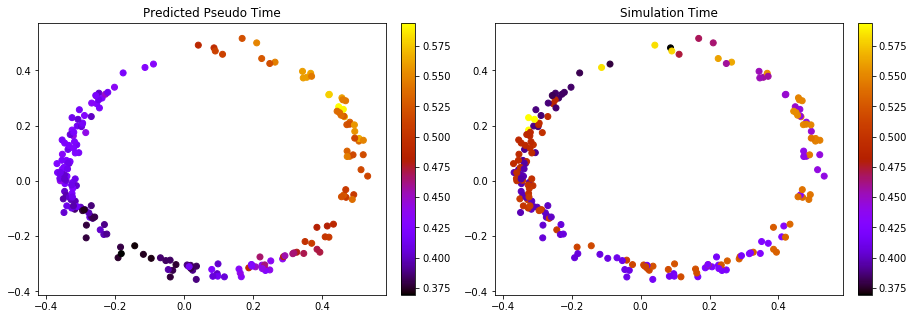

<Figure size 1080x360 with 0 Axes>

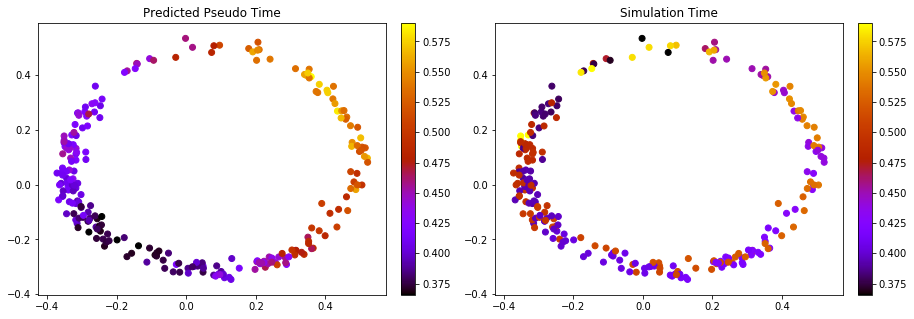

<Figure size 1080x360 with 0 Axes>

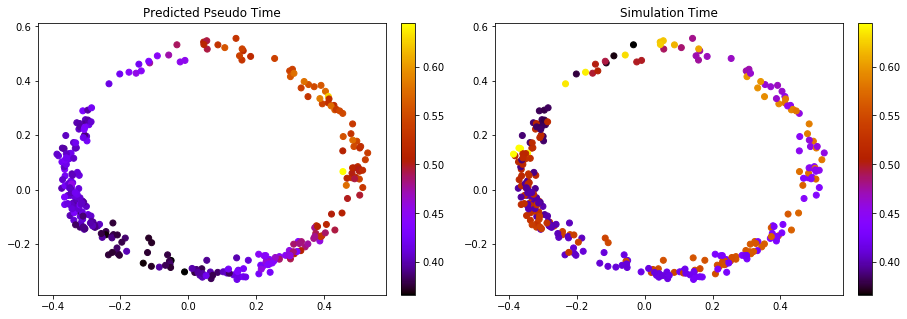

<Figure size 1080x360 with 0 Axes>

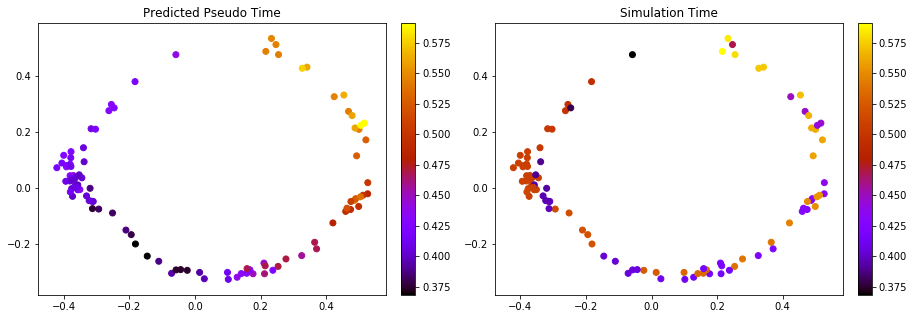

<Figure size 1080x360 with 0 Axes>

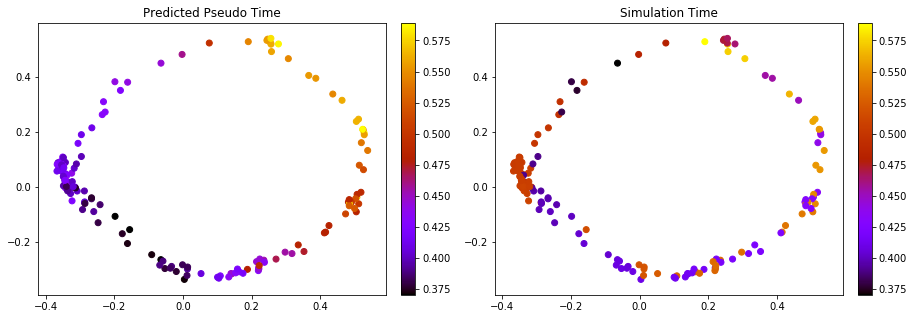

<Figure size 1080x360 with 0 Axes>

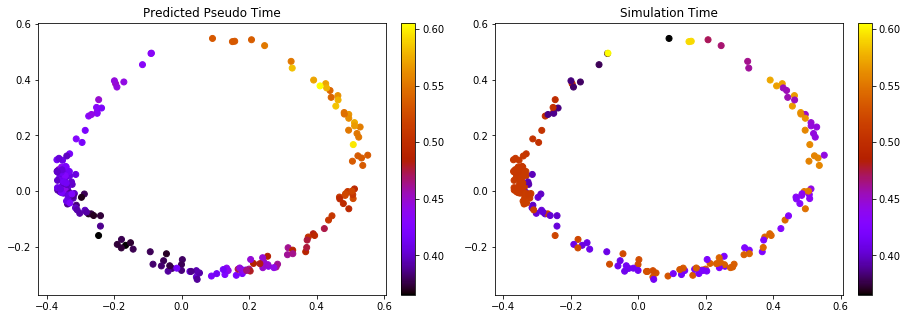

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

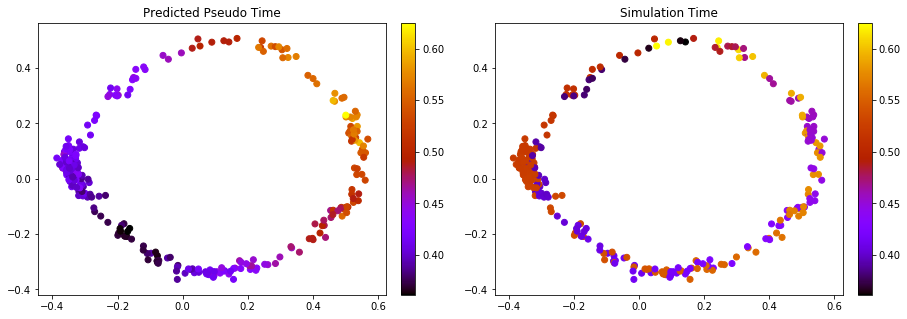

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

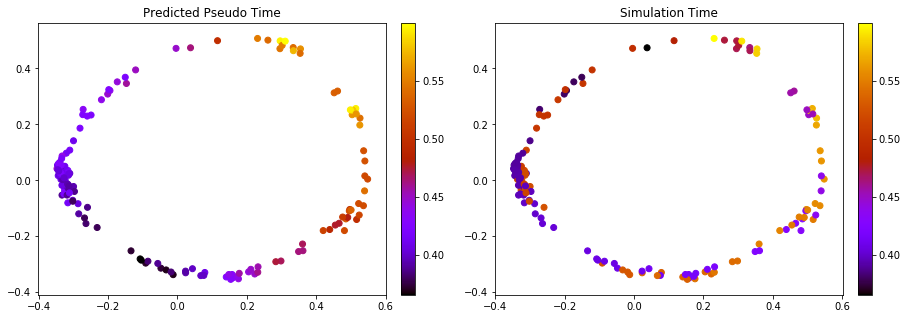

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

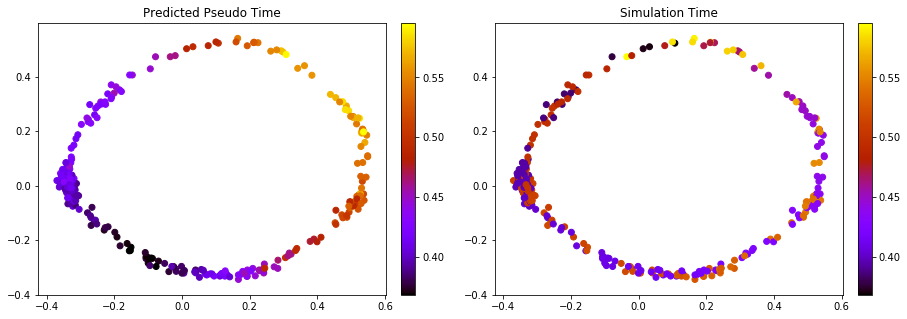

<Figure size 1080x360 with 0 Axes>

In [69]:
model.eval()
for i in range(30, 45):
    scatter(dataset[i])

In [70]:
for i in range(30, 45):
    adata = adata_list[i]
    scv.tl.velocity_graph(adata)
    adata.obs['predict_pseudo_time'] = model(data.to(device)).detach().cpu().numpy().reshape(-1)
    scv.pl.scatter(adata, color=['predict_pseudo_time','sim_time'], color_map='gnuplot', legend_loc='on data', basis='pca')

computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


ValueError: Length of values does not match length of index